# Forecasting Model for Cell Differentation
### This project splits the biological data by

Note: In order to run the program, you must have all the following libraries imported into your database and replicate the setup.

The code is mostly written in the shared_utils file, but explained functionally here.

## Imports

In [1]:
from shared_utils import *

2025-11-27 14:02:14.669342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This command imports all neccacary functions from shared_utils.py in order for the program to run. The program is written this way to keep it modular and not too overwhelming in this notebook where the code is run.

## Loading Data

### Load Data from [GSE75748](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748)

The biological data are the temporal 758 single cells that differentiate from the mesoderm phase to the definitive endoderm.

In [ ]:
print("Starting Cell-Based Forecasting...")

adata = load_data()

Starting Cell-Based Forecasting...
Loading data from GSE75748_sc_time_course_ec.csv...
Extracting timepoints from cell names to add to adata
Timepoint data added to adata.
QC metrics added to adata.obs:
['n_genes_by_counts', 'total_counts']


AnnData object with n_obs × n_vars = 758 × 19189
    obs: 'timepoint', 'sample_number', 'n_genes_by_counts', 'total_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

The load_data() function uses pandas to read the large csv data file under the local variable df. Then once we have the csv file in df, the function converts it into a scanpy variable "adata" for biological preprocessing and visualization, and returns it into the public variable name "adata" which we can now use. 

In [9]:
adata = add_timepoint_data_to_adata(adata) 

Extracting timepoints from cell names to add to adata
Timepoint data added to adata.


Next, we want to add timepoints to the scanpy variable adata so that we can section the data by timepoint, a process that is very important for temporal data like cell differentiation. The temporal data can actually be extracted from the cell names since they start with H9.__h and the timepoint is there instead of the blank. So all we do to add the timepoint data into it's own column in adata is extract the timepoint from the names of the cells and add it into the column for each cell.

In [10]:
add_qc_metrics(adata)

QC metrics added to adata.obs:
['n_genes_by_counts', 'total_counts']


AnnData object with n_obs × n_vars = 758 × 19189
    obs: 'timepoint', 'sample_number', 'n_genes_by_counts', 'total_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

The function makes gene names unique and flags mitochondrial genes in adata.var. It then computes per-cell QC metrics (total_counts, n_genes_by_counts, pct_counts_mt) and returns the annotated AnnData without filtering or removing anything.

Plotting before filtering...


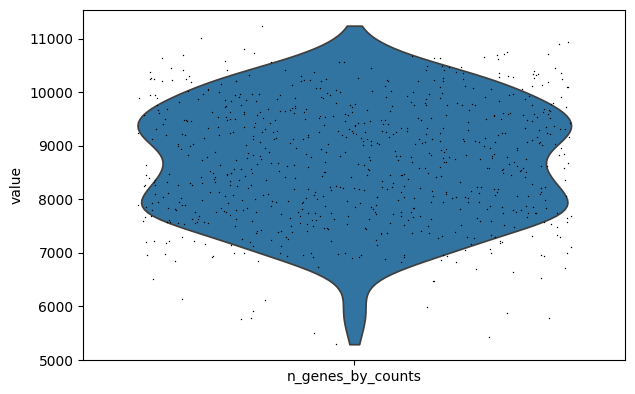

In [11]:
plot_before_filtering(adata) 

We can see from the graph that our expression data is extremely varied before filitering. This graph highlights why it is important to do preprocessing, especially in the biological sense, because in order for the models to perform well, they must read off patterns. And patterns are easily recognized with more concise data rather than the random mess we have with real expression data.

## Data Preprocessing

In [13]:
adata_hvg = preprocess_data(adata)

Starting data preprocessing
Filtering cells and genes

Data shape after filtering: (758, 16863)

Normalizing and log transforming data


HVG filtering:
Highly variable genes found: 2000
After HVG filtering:

[0, 12, 24, 36, 72, 96]


Single-cell RNA sequencing data needs cleaning and processing before it can be used. Cells expressing fewer than 500 genes were removed, and genes expressed in fewer than 3 cells were also removed becausethey did not provide enough useful information. Normalization was applied so that very highly expressed genes did not dominate the results. A standard log-transformation was used. In the end, adata_hvg contains the 2000 most variable genes (from 19189) across all 758 cells. We select the most variable genes because they give us the most expression data to work.

In [19]:
gene_time_matrix, _ = create_gene_time_matrix(adata_hvg)

Creating gene-time matrix
  Expression data shape: (92, 2000)
  Sample values: [1.06525890e-03 1.83659651e+00 6.07498533e-01]...

  Expression data shape: (102, 2000)
  Sample values: [0.00105627 0.36513232 0.55956094]...

  Expression data shape: (66, 2000)
  Sample values: [0.0053351  0.25281378 0.10561054]...

  Expression data shape: (172, 2000)
  Sample values: [0.0036584  0.75394466 0.18623813]...

  Expression data shape: (138, 2000)
  Sample values: [4.36164506e-04 1.05440790e+00 1.25326741e+00]...

  Expression data shape: (188, 2000)
  Sample values: [0.01164793 0.91026402 1.5075981 ]...

Gene-time matrix fully created with shape: (2000, 6)


This function builds a gene-time matrix by averaging gene expression values across all cells belonging to each timepoint. For every timepoint, it selects the cells measured at that time, extracts their expression matrix, and computes the mean expression for each gene. The output show how many cells were present at each timepoint (for example, 92, 102, 66, etc.) and a few sample averaged values for the first three genes. These averaged values become a single column in the final matrix. After processing all timepoints, the resulting matrix has one row per gene and one column per timepoint. In the output, the matrix shape is (2000, 6), meaning 2,000 genes and 6 timepoints. This format provides a clean summary of expression trends over time, where each row represents how a gene’s average expression changes across the measured timepoints. Additionlly this matrix will make splitting the code especially easy.

## Splitting Data and Creating Windows

In [6]:
train_data, val_data, test_data = split_by_cells(gene_time_matrix)
X_train, y_train = create_cell_windows(train_data, window_size=2)
X_val, y_val = create_cell_windows(val_data, window_size=2)
X_test, y_test = create_cell_windows(test_data, window_size=2)

input_shape = (X_train.shape[1], X_train.shape[2]) 
output_size = y_train.shape[1] if y_train.ndim > 1 else 1 


Temporal holdout splitting: 6 timepoints total
Train: timepoints 0-3 (4 points)
Val: timepoints 2-4 (3 points)
Test: timepoints 3-5 (3 points)
Cell windows created: 2 samples. X shape: (2, 2, 2000), y shape: (2, 2000)
Cell windows created: 1 samples. X shape: (1, 2, 2000), y shape: (1, 2000)
Cell windows created: 1 samples. X shape: (1, 2, 2000), y shape: (1, 2000)


## Building the LSTM and Feedforward Models

In [ ]:

lstm_model = build_lstm_model(input_shape, output_size)
ff_model = build_feedforward_model(input_shape, output_size)

print("\nTraining LSTM Model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=250,
    verbose=1,
    callbacks=get_training_callbacks()
)
print(f"LSTM training completed after {len(lstm_history.history['loss'])} epochs.")

print("\n--- Training Feedforward Model ---")
ff_history = ff_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=250,
    verbose=1,
    callbacks=get_training_callbacks()
)
print(f"Feedforward training completed after {len(ff_history.history['loss'])} epochs.")

In [ ]:
# 5. Evaluate models on the test set
print("\n--- Final LSTM Model Evaluation ---")
y_pred_lstm = lstm_model.predict(X_test)
lstm_rmse, lstm_mae, lstm_r2, y_pred_lstm = evaluate_performance(y_test, y_pred_lstm)

print("\n--- Final Feedforward Model Evaluation ---")
y_pred_ff = ff_model.predict(X_test)
ff_rmse, ff_mae, ff_r2, y_pred_ff = evaluate_performance(y_test, y_pred_ff)

In [ ]:
# 6. Plot results for visualization and comparison
print("\n--- Plotting Training Histories ---")
plot_training_history(lstm_history, model_name="LSTM")
plot_training_history(ff_history, model_name="Feedforward")

print("\n--- Plotting Prediction Comparisons ---")
lstm_metrics = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R²': lstm_r2}
plot_prediction_comparison(y_test, y_pred_lstm, model_type='cell', metrics_dict=lstm_metrics)

ff_metrics = {'RMSE': ff_rmse, 'MAE': ff_mae, 'R²': ff_r2}
plot_prediction_comparison(y_test, y_pred_ff, model_type='cell', metrics_dict=ff_metrics)

In [ ]:
#7. Plot diagnostic plots
print("\n--- Plotting Diagnostic Plots ---")
plot_diagnostic_plots(y_test, y_pred_lstm, model_name="LSTM")
plot_diagnostic_plots(y_test, y_pred_ff, model_name="Feedforward")

In [ ]:
#8. Plot comparison bar chart
print("\n--- Plotting Final Performance Comparison ---")
lstm_metrics = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R²': lstm_r2}
ff_metrics = {'RMSE': ff_rmse, 'MAE': ff_mae, 'R²': ff_r2}
plot_performance_comparison_bar_chart(lstm_metrics, ff_metrics)